<a href="https://colab.research.google.com/github/DevDSVik/NLP-Assignment1/blob/main/Final_Copy_of_Assignment_1_for_DS_207_(Intro_to_NLP)_Word_Representation_and_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Word Representation and Text Classification

In this assignment you will explore the different types of text representations, similarity functions and tackle the problem of multi-class text classification. Please make a copy of this notebook (locally or on Colab). Ensure you adhere to the guidelines and submission instructions (mentioned below) for attempting and submitting the assignment.

One of the tasks in this assignment is compute intensive, and is better performed on an accelerator device (GPU, etc.). Unless you have one locally, prefer using a GPU instance on Colab for execution.

## Guidelines for Attempting the Assignment


1. Please read the function docs and comments carefully. They provide specific instructions and examples for implementing each function. Follow these instructions precisely - neither oversimplify nor overcomplicate your implementations. Deviating from the provided implementation guidelines may result in lost marks.

2. Write your logic in the cells which have the comment `# ADD YOUR CODE HERE`, between the `# BEGIN CODE` and `# END CODE` comments. These cells are also demarcated by the special start (`# ==== BEGIN EVALUATION PORTION`) and end (`# ==== END EVALUATION PORTION`) comments.

3. Do **NOT** remove any of these comments from the designated cells, otherwise your assignment may not be evaluated correctly.

4. All imports that should be necessary are already provided as part of the notebook. Should you require additional imports, add them in the cells to be graded, but outside the `# BEGIN CODE` and `# END CODE` block. For example, if you need to import a package called `mypackage`, add it as follows in a graded cell:

``` python
## ==== BEGIN EVALUATION PORTION

import mypackage # <===

def function_to_be_implemented(*args, **kwargs):

    ...

    # BEGIN CODE: block.segment

    # ADD YOUR CODE HERE

    # END CODE

    ...

## ==== END EVALUATION PORTION

```
5. Do not modify anything in the cells which start with `# Please do not change anything in the following cell`.

6. Ensure you only add code in designated areas, otherwise you assignment will not be evaluated. If you encounter any errors in the supporting cells during execution, contact the respective TAs.

7. Ensure that the total runtime of the assignment is less than 20 minutes. Exceeding this time may result in deductions of marks.

8. **Important**: Use of AI-assistive technologies such as ChatGPT or GitHub CoPilot is not permitted for this assignment. Ensure that all attempts are solely your own. Not following this rule can incur heavy penalty, including getting NO GRADE for this assignment.


### Submission Instructions

1. When you have completely attempted the assignment, **export the current notebook as a `.py` file**, with the following name: `SAPName_SRNo_assignment1.py`, where `SAPName` would be your name as per SAP record, and `SRNo` will be the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would use `Twyla_Linda_15329_assignment1.py`.

2. You should put your assignment file `SAPName_SRNo_assignment1.py` inside a folder `SAPName_SRNo`. The folder structure looks as follows:

``` python
└─── SAPName_SRNo
     ├─── SAPName_SRNo_assignment1.py
```

3. Once you have validated the folder structure as above, zip the folder and name it as `submission.zip` and submit this ZIP archive.

4. When you run the assignment code, it may download certain datasets and other artifacts. These should **NOT** be part of the above folder.


**If you have any confusion regarding submission instructions, please ask the respective TAs.**

## Marks Distribution

- Generative Classification: 30 marks
- SkipGram Training and Word2Vec: 40 marks
- Discriminative Classification: 30 marks

In the cell below, replace `SAP_Name` with your name as per SAP record, and `SRNo` with the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would use:

```python
STUDENT_SAP_NAME  = "Twyla_Linda"
STUDENT_SR_NUMBER = "15329"
```

In [ ]:
STUDENT_SAP_NAME  = "Vikash_Singh"
STUDENT_SR_NUMBER = "26142"

# 🗞️ Timothy and the Impossible Inbox

Every morning at The Daily Byte, one person opens an inbox that should not exist. That person is Timothy

Timothy works at one of the biggest news groups in the world. While the newsroom has 5 departments, hundreds of sub-departments, thousands of journalists, and countless dashboards, the very first stop for every article is Timothy's screen. Politics. Sports. Technology. Business. Entertainment. Thousands of articles arrive each day that need to be redirected to the right department.

Timothy reads headlines at the speed of light, skims paragraphs faster than most people blink, and still falls behind before lunch. Manual redirection is not just inefficient, it is impossible. The inbox grows. Deadlines glare. Coffee cools untouched.

Timothy is curious, stubborn, and slightly allergic to doing the same task twice. Faced with an inbox that grows faster than human attention, Timothy decides to automate the problem. Late nights find Timothy reading articles on Natural Language Processing. Some papers talk about simple probabilistic models. Others describe dense word representations and neural networks. The ideas are promising, but the implementations are unfinished, messy, or missing entirely.

Timothy sketches pipelines on sticky notes:

- “Can machines decide where an article belongs?”

The theory is clear. The execution is not. That is when Timothy turns to you.

**You are part of Timothy's newly formed NLP task force.**

Timothy understands the ideas, but needs help turning theory into working systems. Your job is to implement, train, test, and evaluate the models Timothy has been reading about. Each section of this assignment corresponds to a method Timothy discovered in the literature.

# Setup

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 37.6 MB/s eta 0:00:00


In [ ]:
import requests
import numpy as np
import pandas as pd
import re
import os
import json
import argparse
import sys
import joblib

import math
from pathlib import Path
import nltk
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from datasets import load_dataset

import torch
from functools import partial
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

from gensim.models import KeyedVectors
import gensim.downloader as api

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Dataset

Timothy has collected a dataset of ~1800 news articles from The Daily Byte and has shared it with the team. The dataset consists of news articles categorized into five mutually exclusive classes: Politics, Entertainment, Sports, Business, and Science/Technology. Each data instance contains a short news article in the field "text", and labels are encoded as integers from 0 to 4 corresponding to the five news categories, in the field "label".

Timothy has split the dataset into a labeled training set (train.csv) and a validation set (val.csv) with balanced classes. You will use the training set for training your classifiers and testing set to test their performance.

You can run the below code snippets to download and load the training and testing sets as Pandas Dataframes. If you are new to Pandas, you can read more about it [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [ ]:
!pip install gdown

In [ ]:
import gdown

file_ids = {
    "train": "1SPmPJ4OQdurBP-uLUwMoynKa7ZhH1iDk",
    "test": "1imCHe_htxStA3JLXYM_mSn3-HnLO96zQ",
}

url_template = "https://drive.google.com/uc?id={file_id}"

# Training and Testing Data with News articles
train_output = "train.csv"
test_output = "test.csv"

gdown.download(url_template.format(file_id=file_ids['train']), train_output, quiet=False)
gdown.download(url_template.format(file_id=file_ids['test']), test_output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1SPmPJ4OQdurBP-uLUwMoynKa7ZhH1iDk
To: /content/train.csv
100%|██████████| 1.88M/1.88M [00:00<00:00, 81.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1imCHe_htxStA3JLXYM_mSn3-HnLO96zQ
To: /content/test.csv
100%|██████████| 401k/401k [00:00<00:00, 37.0MB/s]


'test.csv'

In case you see an error like -
```
package not found gdown
```
Restart the session and you should be fine.

In [ ]:
train_df = pd.read_csv(train_output)
test_df = pd.read_csv(test_output)

print("Number of training samples - ", len(train_df))
print("Number of testing samples - ", len(test_df))

Number of training samples -  1557
Number of testing samples -  334


# 1. Generative Modeling with Naive Bayes


Timothy finds a book that describes text classification as a **generation problem**. Given a document and a set of possible classes it can belong to, they ask

> *Which class was most likely to generate/have this document?*

This idea leads Timothy to **Naive Bayes**.

Let:

- Let $X = (w_1, w_2, \dots, w_n)$ be a document or a piece of text with multiple words
- Let $y$ be a class (Politics, Sports, Technology, etc.)


Using Bayes' Theorem:

$$
P(y \mid X) = \frac{P(X \mid y) \space P(y)}{P(X)}
$$

Since $ P(d) $ is constant across classes, Timothy only needs to compute:

$$
P(y \mid X) \propto P(y) \space P(X \mid y)
$$

<!-- where
- $P(c \mid d)$ is the posterior probability
- $P(c)$ is the prior probability of the class
- $P(d \mid c)$ is the likelihood of the document given the class -->

### The “Naive” Assumption

Naive Bayes assumes **conditional independence of words** (This assumption is clearly unrealistic. Words influence each other. Hence the name "naive"):

$$
P(X \mid y) = \prod_{i=1}^{n} P(w_i \mid y)
$$

Hence using both the equations

$$
P(X \mid y) \propto P(y) \space \prod_{i=1}^{n} P(w_i \mid y)
$$

In a computer system, if the probabilities are too low and/or the document has a large number of words, it can lead to numerical underflow (think about why). **Log space** is used to prevent numerical underflow:

$$
log(P(X \mid y)) \propto log(P(y)) + \sum_{i=1}^{n} log(P(w_i \mid y))
$$

Timothy further reads that a special token called **UNK token** is used for words that are not found in the vocabulary but are encountered during prediction!

Timothy shares the book with you. You find that some parts of the code in the book is missing. Complete the below code to implement **Generative Classification using Naive Bayes**.

### 1.1 Create a Vocabulary

In [ ]:
# ==== BEGIN EVALUATION PORTION

def preprocess_text(text):
    """
    Before working with any text data, we need to clean the data and remove all noisy elements.
    In this function, we preprocess the input text by converting everything to lowercase,
    removing non-word characters and filtering out stop words.

    The preprocessing pipeline performs the following steps:
    1. Converts the text to lowercase.
    2. Removes punctuation and non-word characters.
    3. Splits the text into individual words.
    4. Filters out common English stop words (e.g., 'a', 'an', 'the', 'is', 'are', 'how')
        using NLTK's stop word list.

    Args:
        text (str): Raw input text
            Example: "Hello, World! How are you doing today?"

    Returns:
        list: List of cleaned, tokenized, and filtered words with stop words removed
            Example: ['hello', 'world', 'doing', 'today'
    """
    # Import stop words from NLTK
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

    # Convert the text to lowercase
    text = text.lower()

    # Extract words and split into tokens
    tokens = re.findall(r'\w+', text)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

def create_vocabulary(texts, min_freq = 1):
    """
    As discussed in class, we create vocabulary from training texts by mapping unique words to indices.
    And to reduce noise, we only include words in the vocabulary that have been encountered at least
    min_freq number of times in the text.

    Complete this method to create a vocabulary from a given list of texts. The vocabulary construction
    process must include:
      1. Preprocessing each document using `preprocess_text`.
      2. Counting word frequencies across the entire corpus and only including words that appear >= min_freq times
      5. `<UNK>` token must be present at index 0. This will be used to map all OOV (Out of Vocabulary) words
          during evaluation.

    Args:
        texts (list): List of text documents
                Example: [
                    "Kohli played well",
                    "Stock markets crashed last sunday",
                    "Harry Styles's new song is out"
         ]
    Returns:
        dict: Mapping of words to unique indices, including UNK token
            Example (with min_freq=2): {
                '<UNK>': 0,    # Special token for rare/unseen words
                'hello': 1,    # Frequency=3, included in vocab
                'world': 2,    # Frequency=2, included in vocab
                # 'there' and 'beautiful' not included (frequency=1 < min_freq=2)
            }
    """

    # BEGIN CODE : preprocess_and_create_vocab

    # ADD YOUR CODE HERE
    word_count= Counter()
    for text in texts:
      tokens= preprocess_text(text)
      word_count.update(tokens)
    vocabulary={'<UNK>':0}
    current_index=1
    for word,count in word_count.items():
      if count>=min_freq:
        vocabulary[word]=current_index
        current_index=current_index+1
    return vocabulary


    # END CODE

# ==== END EVALUATION PORTION

### 1.2 Train a Naive Bayes Classifier

In [ ]:
# ==== BEGIN EVALUATION PORTION

class NaiveBayesClassifier:
    def __init__(self, min_freq=1):
        """
        Here we initialize the Naive Bayes classifier.

        Args:
            min_freq (int): Minimum frequency threshold for a word to be included in vocabulary.
                           Words appearing less than min_freq times will be treated as UNK token.
                           Default: 1 (include all words)

        Attributes:
            class_probs (dict): P(y) for each class
                Example: {0: 0.5, 1: 0.5}

            word_probs (dict): P(X|y) for each word and class
                Example: {
                    1: {'cricket': 0.2, 'computer': 0.3, '<UNK>': 0.1},
                    2: {'cricket': 0.9, 'computer': 0.1, '<UNK>': 0.1},
                    3: {'cricket': 0.3, 'computer': 0.6, '<UNK>': 0.1},
                    4: {'cricket': 0.1, 'computer': 0.9, '<UNK>': 0.1}
                }

            vocabulary (dict): Word to index mapping, including special UNK token
                Example: {'<UNK>': 0, 'cricket': 1, 'computer': 2}

            min_freq (int): Minimum frequency threshold for vocabulary inclusion
        """
        self.class_probs = None
        self.word_probs = None
        self.vocabulary = None
        self.min_freq = min_freq

    def calculate_class_probabilities(self, labels):
        """
        Complete this function to estimate probability P(y) for each class from training labels.
        Recall that for Naive Bayes event A, P(A) = Number of occurrences of A / Total Samples
        This code should handle ANY number of unique classes.

        Sanity Check:
            - Probabilities must sum to 1 across all classes

        Args:
            labels (list): List of class labels
                Example: [3, 0, 1, 2, 0, 1]

        Returns:
            dict: Estimated probability for each class
                Example: {
                    0: 0.33,     # 2 out of 6 samples are class 0
                    1: 0.33,     # 2 out of 6 samples are class 1
                    2: 0.17,     # 1 out of 6 samples are class 2
                    3: 0.17,     # 1 out of 6 samples are class 3
                    4: 0.00      # 0 out of 6 samples are class 4
                }

        """
        # BEGIN CODE : naive_bayes.calculate_class_probabilities

        # ADD YOUR CODE HERE
        class_count=Counter(labels)
        total_samples=len(labels)
        class_probability={}
        for class_label,count in class_count.items():
          class_probability[class_label]=count/total_samples

        return class_probability



        # END CODE

    def calculate_word_probabilities(self, texts, labels, vocabulary, alpha=1.0):
        """
        Complete this function to calculate conditional probability P(X|y) for each word X and class y,
        including probability for <UNK> token.

        The vocabulary construction process must include:
          1. Preprocess each document using `preprocess_text`.
          2. Replace OOV words (words not in vocabulary) with UNK token.
          3. Use Laplace smoothing to handle unseen words
            P(X|y) = (count(X,y) + α) / (total_words_in_class + α|V|)
            where |V| is vocabulary size (including <UNK> token)


        Args:
            texts (list): List of text documents
                Example: [
                    "Kohli played well",
                    "Stock markets crashed last sunday",
                    "Harry Styles's new song is out"
                ]
            labels (list): Class labels
                Example: [0, 1]
            vocabulary (dict): Word to index mapping with <UNK> token
                Example: {'<UNK>': 0, 'hello': 1, 'world': 2}
            alpha (float): Laplace smoothing parameter, default=1.0

        Returns:
            dict: Nested dict with P(X|y) for each word X and class y
                Example: {
                    0: {
                        '<UNK>': 0.167,    # P(X=<UNK>|y=0)
                        'hello': 0.5,      # P(X='hello'|y=0)
                        'world': 0.333     # P(X='world'|y=0)
                    },
                    1: {
                        '<UNK>': 0.4,     # P(X=<UNK>|y=1)
                        'hello': 0.2,     # P(X='hello'|y=1)
                        'world': 0.4      # P(X='world'|y=1)
                    }
                }
        """

        # BEGIN CODE : naive_bayes.calculate_word_probabilities

        # ADD YOUR CODE HERE
        classes=set(labels)
        vocabulary_size=len(vocabulary)
        word_probability={c: {} for c in classes}
        class_word_count=defaultdict(Counter)
        class_total_words=defaultdict(int)
        for text,label in zip(texts,labels):
          tokens=preprocess_text(text)
          for token in tokens:
            word=token if token in vocabulary else '<UNK>'
            class_word_count[label][word]+=1
            class_total_words[label]+=1
        for c in classes:
          d=class_total_words[c]+(alpha*vocabulary_size)
          for word in vocabulary:
            n=class_word_count[c][word]+alpha
            word_probability[c][word]=n/d
        return word_probability


        # END CODE

    def fit(self, texts, labels):
        """
        In the function we train the Naive Bayes classifier on the provided text documents.

        Args:
            texts (list): List of text documents
                Example: [
                    "Kohli played well",
                    "Stock markets crashed last sunday",
                    "Harry Styles's new song is out"
                ]
            labels (list): Class labels
                Example: [2, 1, 3]
        """
        # Create vocabulary from training texts
        self.vocabulary = create_vocabulary(texts, self.min_freq)

        # Calculate probabilities
        self.class_probs = self.calculate_class_probabilities(labels)
        self.word_probs = self.calculate_word_probabilities(texts, labels, self.vocabulary)

    def predict(self, texts):
        """
        Complete this function to predict classes for new documents using Naive Bayes algorithm,
        handling unknown words using <UNK> token.

        For each document:
            1. Preprocess the text using ``preprocess_text``.
            2. Replace OOV words (out-of-vocabulary or words not in vocabulary) with UNK token.
            3. Calculate log probabilities using appropriate word or UNK probabilities.
               UNK probability is used for OOV (out-of-vocabulary) words.
            4. Return class with highest log probability score.

        Args:
            texts (list): List of text documents
                Example: [
                    "Kohli played well",
                    "Stock markets crashed last sunday",
                    "Harry Styles's new song is out"
                ]

        Returns:
            list: Predicted class labels
                Example: [2, 1, 3]
        """
        # BEGIN CODE : naive_bayes.predict

        # ADD YOUR CODE HERE
        predictions=[]
        for text in texts:
          tokens=preprocess_text(text)
          class_scores={}
          for cls in self.class_probs:
            log_probability=math.log(self.class_probs[cls])
            for token in tokens:
              word=token if token in self.vocabulary else '<UNK>'
              prob_word_given_class=self.word_probs[cls][word]
              log_probability+=math.log(prob_word_given_class)
            class_scores[cls]=log_probability
          predicted_class=max(class_scores,key=class_scores.get)
          predictions.append(predicted_class)
        return predictions


        # END CODE

    def get_important_words(self, n=5, use_ratio=True):
        """
        In the function we get the most important words for each class based either on their raw conditional
        probabilities or their probability ratios between classes.

        Args:
            n (int): Number of top words to return for each class, default=5
            use_ratio (bool): If True, ranks words by probability ratio between classes
                            If False, ranks words by raw conditional probability

        Returns:
            dict: Dictionary mapping class labels to lists of (word, score) tuples,
                where score is either probability or probability ratio

                Example with use_ratio=False:
                {
                    0: [('excellent', 0.014), ('great', 0.012), ('amazing', 0.011)],
                    1: [('terrible', 0.015), ('bad', 0.012), ('boring', 0.008)],
                    2: [('politics', 0.018), ('election', 0.014), ('policy', 0.010)]
                }

                Example with use_ratio=True:
                {
                    0: [('excellent', 6.8), ('amazing', 5.9), ('great', 5.2)],
                    1: [('terrible', 7.4), ('awful', 6.3), ('bad', 5.7)],
                    2: [('election', 8.1), ('policy', 6.9), ('vote', 6.2)]
                }

    Notes:
        - When use_ratio=True:
            - For each class c, words are ranked by:
                P(word | c) / average P(word | other classes)
            - This highlights words that are distinctive for a class relative to all other classes.
            - This helps reduce overlap between top words across classes.
        - When use_ratio=False:
            - Words are ranked by raw P(word | class).
            - Common words may appear in multiple classes.
        - Includes the UNK token only if it ranks among the top n words.
        - Small probabilities are handled safely to avoid division by zero.
        """
        if not self.word_probs:
            raise ValueError("Classifier must be trained before getting important words")

        important_words = {}
        classes = sorted(self.word_probs.keys())

        for cls in classes:
            # Get next class
            other_classes = [c for c in classes if c != cls]

            if use_ratio:
                # Probability ratios for all words
                word_scores = []
                for word in self.vocabulary:
                    numerator = self.word_probs[cls][word]
                    denominator = sum(self.word_probs[c][word] for c in other_classes) / len(other_classes)
                    ratio = numerator / (denominator + 1e-4)
                    word_scores.append((word, ratio))
            else:
                # Use raw probabilities
                word_scores = list(self.word_probs[cls].items())

            # Sort by score (either ratio or probability) and take top n
            sorted_words = sorted(word_scores, key=lambda x: x[1], reverse=True)
            important_words[cls] = sorted_words[:n]

        return important_words

# ==== END EVALUATION PORTION

### 1.3 Evaluate the Naive Bayes Model

Before sharing the code with Timothy, you want to verify if it runs. You note down a few sentences related to each of the 5 departments and check if it works.

In [ ]:
# Minimum frequency of words to be present in the vocabulary.
# You can play with the value of min_freq and notice how the top words converge for larger values
# and <UNK> dominates. This is because we are testing in a tiny universe.

# ADD YOUR CODE HERE

MIN_FREQ = 2

In [ ]:
def train_and_evaluate_sample_data(use_ratio=False):

    X_train = [
      # ---- Tech (0) ----
      "AI neural network improves deep learning accuracy",
      "Quantum computing processor accelerates machine learning tasks",
      "Cybersecurity researchers detect ransomware malware attack",
      "Software engineers release open source encryption library",
      "Cloud computing platform optimizes data center performance",

      # ---- Business (1) ----
      "Stock market investors react to quarterly earnings report",
      "Corporate merger increases company valuation and revenue",
      "Bank reports profit growth amid rising interest rates",
      "Shareholders approve acquisition during annual meeting",
      "Financial analysts predict economic slowdown and inflation",

      # ---- Sport (2) ----
      "Football team wins championship after penalty shootout",
      "Cricket batsman scores century in international match",
      "Olympic athlete suffers injury before major tournament",
      "Coach announces squad for upcoming league season",
      "Referee awards red card during intense derby match",

      # ---- Entertainment (3) ----
      "Hollywood movie premieres at international film festival",
      "Actor receives award for outstanding performance",
      "Pop singer releases album topping music charts",
      "Streaming series gains popularity among young audiences",
      "Director praises cast during cinema award ceremony",

      # ---- Politics (4) ----
      "Parliament passes bill after heated legislative debate",
      "Election campaign focuses on healthcare and education policy",
      "Government announces new foreign policy strategy",
      "Opposition party criticizes tax reform proposal",
      "Prime minister addresses nation on climate change"
    ]

    y_train = (
        [0] * 5 +
        [1] * 5 +
        [2] * 5 +
        [3] * 5 +
        [4] * 5
    )

    X_val = [
        "Breakthrough in artificial intelligence research",
        "Company shares fall after profit warning",
        "Final match ends in dramatic penalty shootout",
        "Actor wins award for leading role",
        "Government announces new foreign policy strategy"
    ]

    y_val = [0, 1, 2, 3, 4]

    # Training classifier
    nb_classifier = NaiveBayesClassifier(min_freq=MIN_FREQ)
    nb_classifier.fit(X_train, y_train)

    # Prediction
    predictions = nb_classifier.predict(X_val)

    # Evaluation
    accuracy = sum(int(p == y) for p, y in zip(predictions, y_val)) / len(y_val)
    print(f"Validation accuracy on the dummy dataset: {accuracy:.4f}")

    # Top words per class
    class_names = {
        0: "Tech",
        1: "Business",
        2: "Sport",
        3: "Entertainment",
        4: "Politics"
    }

    important_words = nb_classifier.get_important_words(n=5, use_ratio=use_ratio)

    for class_label, words in important_words.items():
        print(f"\nTop words for {class_names[class_label]}:")
        for word, prob in words:
            print(f"{word}: {prob:.4f}")

# Don't worry about the accuracy here.
train_and_evaluate_sample_data(use_ratio=False)

Validation accuracy on the dummy dataset: 0.8000

Top words for Tech:
<UNK>: 0.6977
learning: 0.0698
computing: 0.0698
performance: 0.0465
international: 0.0233

Top words for Business:
<UNK>: 0.8049
learning: 0.0244
computing: 0.0244
performance: 0.0244
international: 0.0244

Top words for Sport:
<UNK>: 0.7000
match: 0.0750
international: 0.0500
announces: 0.0500
learning: 0.0250

Top words for Entertainment:
<UNK>: 0.7000
award: 0.0750
performance: 0.0500
international: 0.0500
learning: 0.0250

Top words for Politics:
<UNK>: 0.7179
policy: 0.0769
announces: 0.0513
learning: 0.0256
computing: 0.0256


In [ ]:
# Does <UNK> dominate the results. Don't worry, this is expected.
# Now let's see how the top performing words change when we use the ratio instead of raw
# probabilities to compare.
train_and_evaluate_sample_data(use_ratio=True)

Validation accuracy on the dummy dataset: 0.8000

Top words for Tech:
learning: 2.7787
computing: 2.7787
performance: 1.4833
<UNK>: 0.9547
match: 0.6184

Top words for Business:
<UNK>: 1.1433
learning: 0.6691
computing: 0.6691
performance: 0.6612
match: 0.6535

Top words for Sport:
match: 3.0399
international: 1.6170
announces: 1.6086
<UNK>: 0.9586
learning: 0.6887

Top words for Entertainment:
award: 3.0399
performance: 1.6401
international: 1.6170
<UNK>: 0.9586
learning: 0.6887

Top words for Politics:
policy: 3.1382
announces: 1.6671
<UNK>: 0.9893
learning: 0.7095
computing: 0.7095


Looks like you are ready to test your model on the Timothy's dataset!

In [ ]:
# For the following evaluation on a much larger universe,
# you can use a larger value of min_freq.
# Notice how min_freq affects the accuracy and top words.

# ADD YOUR CODE HERE

MIN_FREQ = 10

In [ ]:
def train_and_evaluate_test_data(train_df, test_df, use_ratio=False):
    """
    Train and evaluate NaiveBayesClassifier on the AG News dataset.

    Args:
        train_path (str): Path to train.csv
        val_path (str): Path to val.csv
    """

    X_train = train_df['text'].tolist()
    y_train = train_df['label'].tolist()
    X_test = test_df['text'].tolist()
    y_test = test_df['label'].tolist()

    # Initialize and train classifier
    nb_classifier = NaiveBayesClassifier(min_freq=MIN_FREQ)
    nb_classifier.fit(X_train, y_train)

    # Make predictions on validation set
    predictions = nb_classifier.predict(X_test)

    # Compute accuracy
    accuracy = sum(int(p == y) for p, y in zip(predictions, y_test)) / len(y_test)
    print(f"Validation Accuracy on AG News: {accuracy:.4f}")

    # Display top words for each class
    class_names = {
        0: "Tech",
        1: "Business",
        2: "Sport",
        3: "Entertainment",
        4: "Politics"
    }
    important_words = nb_classifier.get_important_words(n=5, use_ratio=use_ratio)

    for class_label, words in important_words.items():
        print(f"\nTop words for {class_names.get(class_label, class_label)}:")
        for word, prob in words:
            print(f"{word}: {prob:.4f}")

# Accuracy above 80% is good.
train_and_evaluate_test_data(train_df, test_df, use_ratio=False)


Validation Accuracy on AG News: 0.9461

Top words for Tech:
<UNK>: 0.1696
industry: 0.0048
users: 0.0048
new: 0.0045
according: 0.0045

Top words for Business:
<UNK>: 0.1532
company: 0.0060
significant: 0.0053
growth: 0.0050
market: 0.0049

Top words for Sport:
<UNK>: 0.1703
team: 0.0061
year: 0.0046
match: 0.0043
6: 0.0041

Top words for Entertainment:
<UNK>: 0.2061
music: 0.0062
film: 0.0061
fans: 0.0045
year: 0.0043

Top words for Politics:
<UNK>: 0.1575
party: 0.0079
government: 0.0072
labour: 0.0051
uk: 0.0049


In [ ]:
# Again, let's see how the top performing words change when we use the ratio instead of raw
# probabilities to compare.
# Accuracy above 80% is good.
train_and_evaluate_test_data(train_df, test_df, use_ratio=True)

Validation Accuracy on AG News: 0.9461

Top words for Tech:
users: 36.4093
software: 20.3892
internet: 15.7515
online: 15.5395
mobile: 13.8482

Top words for Business:
investors: 18.7062
oil: 13.1347
bank: 11.4349
stock: 11.1654
economy: 10.7005

Top words for Sport:
match: 23.2115
coach: 17.6201
cup: 16.0128
tennis: 15.9682
squad: 14.7948

Top words for Entertainment:
film: 30.8105
festival: 16.2833
awards: 15.8445
rock: 14.7525
audiences: 13.5148

Top words for Politics:
labour: 35.9984
blair: 31.0117
party: 28.1677
conservative: 19.4817
election: 16.1556


Timothy is happy with your results. But he is not convinced that this is the best way. So he continues digging.

# 2. Training your own Word2Vec Model



Timothy found that some papers argue that **meaning is not counted, but inferred**. Words mean what they do because of the words they appear near. This leads Timothy to **Word2Vec**.

### Skip-Gram Training

For target word $w_t$ we predict its surrounding context words $w_c$. Given a center word $w_t$ and a context window $n$,the objective is to maximise the likelihood of observing surrounding words in the range $w_{t-j}$ to $w_{t+j}$
$$
maximise \sum_{t=1}^{T} \sum_{w_c \in \text{Context}(t)} \log P(w_c \mid w_t ; \theta) \\
= maximise \sum_{t=1}^{T} \sum_{-n \le j \le n \\ j\ne 0} \log P(w_{t+j} \mid w_t ; \theta)
$$

Word2Vec represents each word as a vector.

Each word $w$ in the vocabulary $V$ is associated with two vectors - the center embedding ($u_w$) and the context/outer embedding ($v_w$). These are stored as two embedding matrices in code. The probability of a context word given a target word is modeled using softmax.

$$
P(w_c \mid w_t) = P(o \mid c) =
\frac{\exp(u_o^T \space v_c)}
{\sum_{w \in V} \exp(u_w^T \space v_c)}
$$

Where:

* $w_t$ = c: center word
* $w_c$ = o: context/outer words
* $v_c$: embedding of the center word
* $u_o$: embedding of a candidate context word
* $u_o^\top v_c$: similarity score (dot product)
* Denominator: normalisation over **all words in the vocabulary**

### The Computational Bottleneck

Timothy quickly notices the trapdoor hidden in the denominator.

The softmax requires a summation over the entire vocabulary for every training pair. For vocabularies with tens or hundreds of thousands of words, this becomes computationally impractical. The model knows which word should be close, but is forced to check **every word it should not be close to**.

## Negative Sampling

Negative Sampling reframes the problem as a set of **binary classification tasks**:

> “Did this word actually appear in the context of the center word, or was it just noise?”

Instead of normalizing over the full vocabulary, the model pulls real context words closer and pushes randomly sampled noise words away

Let:

* $D$: set of positive pairs (true center-context pairs occurring in text)
* $D'$: set of negative pairs (randomly sampled word pairs)

For each positive pair $(c, o)$, we sample $k$ negative words $o' \sim P_n(w)$. The training objective becomes:

$$
\max_\theta
\prod_{(c,o)\in D} \sigma(u_o^\top v_c)
\prod_{(c,o')\in D'} \sigma(-u_{o'}^\top v_c)
$$

Or equivalently, in log space:

$$
\max_\theta
\sum_{(c,o)\in D} \log \sigma(u_o^\top v_c)
\space +
\sum_{(c,o')\in D'} \log \sigma(-u_{o'}^\top v_c)
$$

$$
= \min_\theta
\space - \{\sum_{(c,o)\in D} \log \sigma(u_o^\top v_c)
\space +
\sum_{(c,o')\in D'} \log \sigma(-u_{o'}^\top v_c)
\}
$$

* $\sigma(u_o^\top v_c)$
  pushes real context words to have high dot products with the center word

* $\sigma(-u_{o'}^\top v_c)$
  pushes noise words to have low dot products

In this exercise, you will code the skipgram model from scratch using the PyTorch library.

**NOTE**: Connect to a GPU runtime for this part of the assignment

## 2.1 Training SkipGram Model with Negative Sampling

In [ ]:
# You can choose and play around with modelling parameters here.
# Note that we will be defining our own set of parameters
# during evaluation, hence the values used here are not indicative of
# the performance of your model.

# ADD YOUR CODE HERE

# Number of context words to consider around the center word
SKIPGRAM_N_WORDS = 4

# Only consider words which occur at least MIN_WORD_FREQUENCY times
MIN_WORD_FREQUENCY = 4

# Truncate long sentences to MAX_SEQUENCE_LENGTH
MAX_SEQUENCE_LENGTH = 64

# Embedding dimension
EMBED_DIMENSION = 300

In [ ]:
# ==== BEGIN EVALUATION PORTION

def tokenize(text):
    """
    Tokenise the text into word in lower case
    """
    pattern = re.compile(r"\b\w+\b")
    return pattern.findall(text.lower())

def load_text(split):
    """
    Load the dataset from HuggingFace.

    Args:
        split (str): The split to load 'train' or 'validation'

    Returns:
        list[str]: List of text lines
    """
    if split == "train":
        dataset1 = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")['train']
        dataset2 = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")['test']
        return [item['text'] for item in dataset1 if item['text'].strip()] + \
               [item['text'] for item in dataset2 if item['text'].strip()]
    elif split == "validation":
        dataset = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")['validation']
        return [item['text'] for item in dataset if item['text'].strip()]
    else:
        raise ValueError(f"Invalid split name: {split}")


def collate_skipgram(batch, vocab, max_sequence_length=MAX_SEQUENCE_LENGTH, window=SKIPGRAM_N_WORDS):
    """
    Complete this function to create (center_word, context_word) pairs for Skip-gram training.

    For each text in a batch:

        - Tokenize the text using ``tokenize``
        - Get the IDs of all tokens (words) in the text that are in the vocabulary.
           If a word is not in the vocabulary, skip it.
        - If the length of the text is > MAX_SEQUENCE_LENGTH, truncate it to MAX_SEQUENCE_LENGTH.
        - For center index i and window size j, context indices are [i-j to i-1] and [i+1 to i+j]
          inclusive of the ends.
        - Create center_words list and context_words list where for every index i, center_words[i]
          and context_words[i] form the (center_word, context_word) pair.

        - IMPORTANT: Convert center_words and context_words to torch.tensor.
          Example - center_words = torch.tensor(center_words, dtype=torch.long)
                    context_words = torch.tensor(context_words, dtype=torch.long)
        - IMPORTANT: Return (center_words, context_words) as a pair. Changing the return object structure
                    may result in loss of marks.

    Args:

        batch(list): List of text documents.

        vocab(dict): A vocabulary object created using ``create_vocabulary``.
            It is a dictionary mapping tokens -> integer ids. <UNK> tokens map to 0.

        max_sequence_length(int): maximum length of a single text to use to create center-context pairs.
            If length of sentence > max_sequence_length, truncate it to max_sequence_length.

        window(int): size of the window to take as context for each middle word.
            Example: [
              "Shalika likes to drink coffee in the morning."
            ]
            If window = 2, for middle word "drink", the pairs will be
            [("drink", "to"), ("drink", "like"), ("drink", "coffee"), ("drink", "in")]

    Returns:
        (torch.tensor, torch.tensor): Tensor of center word ids and Tensor of context word ids
    """

    # BEGIN CODE : skipgram_init.collate_skipgram

    # ADD YOUR CODE HERE
    context_words_list=[]
    center_words_list=[]
    for text in batch:
        tokens = tokenize(text)
        token_ids=[]
        for token in tokens:
          if token in vocab:
            token_ids.append(vocab[token])
        if len(token_ids) > max_sequence_length:
            token_ids = token_ids[:max_sequence_length]
        doc_len = len(token_ids)
        for i in range(doc_len):
          center_id=token_ids[i]
          begin=max(0,i-window)
          finish=min(doc_len,i+window+1)
          for j in range(begin,finish):
            if j!=i:
              context_id=token_ids[j]
              center_words_list.append(center_id)
              context_words_list.append(context_id)

    context_words = torch.tensor(context_words_list, dtype=torch.long)
    center_words = torch.tensor(center_words_list, dtype=torch.long)
    return center_words, context_words


    # END CODE


def get_dataloader_and_vocab(split, batch_size, shuffle, min_freq, vocab=None):
    """
    Get the dataloader and vocabulary for the given split.

    Args:
        split(str): 'train' or 'val'
        batch_size(int): Batch size
        shuffle(bool): Whether to shuffle the dataset
        min_freq(int): Minimum frequency of words to include in vocabulary.
            Words with frequency < min_freq are not included.
        vocab(dict): Mapping of words to unique indices, including UNK token

      Returns:
        dataloader(torch.utils.data.DataLoader): Dataloader for the given split
        vocab(dict): Mapping of words to unique indices, including UNK token
    """
    texts = load_text(split)

    if vocab is None:
        vocab = create_vocabulary(texts, min_freq)

    dataloader = DataLoader(
        texts,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_skipgram, vocab=vocab),
    )

    return dataloader, vocab

# ==== END EVALUATION PORTION

### You will have to implement the Forward Pass below.

For each training example, we are given
- a center word c
- one true context word o
- K negative words

Let B = batch size and d = embedding dimension. In this forward function signature,

- center_words has shape (B, )
- context_words has shape (B, )
- negative_words has shape (B, K, )

The corresponding embedding tensors are,

- $v_c$  = center_embeddings(center_words) with shape (B, d). $v_{c_i}$ denotes the embedding vector of the $i^{th}$ center word.
- $u_o$  = context_embeddings(context_words) with shape (B, d). $u_{o_i}$ denotes the embedding vector of the true context word $o_i$ corresponding to the $i^{th}$ center word.
- $u_{o'}$ = context_embeddings(negative_words) with shape (B, K, d).
$u_{{o'}_{i,k}}$ denotes the embedding vector of the $k^{th}$ negative word corresponding to the $i^{th}$ center word.

For the i-th example in the batch, the **positive score** is defined as:
$$
s_{pos}(i) = v_{c_i}^T u_{o_i}
= \sum_j v_c[i, j] · u_o[i, j]
$$

The positive score is computed by taking an elementwise product
between v_c and u_o and summing over the embedding dimension. Similarly the negative scores for the i-th example and k-th negative sample associated with it is defined as:
$$
s_{neg}(i, k) = v_{c_i}^T u_{o'_{i,k}}
= \sum_j v_c[i, j] \cdot u_{o'}[i, k, j]
$$

The negative scores are computed by taking an elementwise product
between v_c and every negative embedding u_o' and summing over the
embedding dimension. Since each center word has K negative words, $v_c$ is reshaped to (B, 1, D) so that it can be multiplied with all K negative vectors
for the same center word using broadcasting.

The function returns pos_score with shape (B,) and neg_score with shape (B, K,).

> Please note that the scores returned by the forward function in our implementation are NOT normalised scores, rather the raw dot products. Normalisation is performed in the `negative_sampling_loss` method that you will encounter in the next step.

In [ ]:
# ==== BEGIN EVALUATION PORTION

class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int, embed_dimension: int = EMBED_DIMENSION):
        super(SkipGram_Model, self).__init__()

        # Embedding matrix for center words (v)
        self.center_embeddings = nn.Embedding(vocab_size, embed_dimension)
        # Embedding matrix for context words (u)
        self.context_embeddings = nn.Embedding(vocab_size, embed_dimension)


    def forward(self, center_words, context_words, negative_words):
        """
        Forward pass of the Skip-Gram model. This method computes scores measuring how well
        a center word predicts surrounding context words. You will be using SkipGram training with
        negative sampling in this implementation.

        Negative Sampling computes similarity scores for:
          (a) (center, context) word pairs
          (b) a small set of randomly sampled negative words

        Forward Training Steps:
          - Get the embeddings for center words (v_c)
          - Get the embeddings for positive (u_o) and negative context words (u_o')
          - Get positive score as dot product of v_c and u_o
          - Get negative score as the dot product of v_c and u_o'
          - Score returned by the forward function is NOT normalised scores, rather the raw dot product.
        Refer to the previous cell to get more information about the scores.

        Args:
          center_words (torch.tensor of shape (batch_size,)): The center word ids
          context_words (torch.tensor of shape (batch_size, )): The context word ids
          negative_words (torch.tensor of shape (batch_size, n_negatives)): Word ids of negative words corresponding the
              the center word and context word in the same index.

        Returns:
          torch.tensor of shape (batch_size,): positive scores
          torch.tensor of shape (batch_size, n_negatives): negative scores
        """

        # BEGIN CODE : skipgram_model.forward

        # ADD YOUR CODE HERE
        v_c = self.center_embeddings(center_words)
        u_o = self.context_embeddings(context_words)
        u_o_neg = self.context_embeddings(negative_words)
        positive_score = torch.sum(v_c * u_o, dim=1)
        negative_score = torch.sum(v_c.unsqueeze(1) * u_o_neg, dim=2)
        return positive_score, negative_score

        # END CODE

# ==== END EVALUATION PORTION

In [ ]:
# ==== BEGIN EVALUATION PORTION

class Trainer:
    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        val_dataloader,
        optimizer,
        lr_scheduler,
        device,
        model_dir,
        model_name,
        num_negatives=5,
    ):

        self.model = model  # Skipgram model
        self.epochs = epochs # Number of epochs to train for
        self.train_dataloader = train_dataloader # Dataloader object to load the training data
        self.val_dataloader = val_dataloader # Dataloader object to load the validation data
        self.optimizer = optimizer # Optimizer object
        self.lr_scheduler = lr_scheduler # Learning rate scheduler
        self.device = device # Device to use (CUDA/CPU)
        self.model_dir = model_dir # Directory we save the model in
        self.model_name = model_name # Name of the model
        self.num_negatives = num_negatives # Number of negative samples per center word
        self.loss = {"train": [], "val": []} # Save the training and validation loss values

        self.model.to(self.device)

    def negative_sampling_loss(self, pos_score, neg_score):
        """
        Negative sampling loss function.

        Recall that the negative sampling loss is given by
        = - {sum[log(sigmoid(pos_score))] + sum[log(sigmoid(-neg_score))]}

        Args:
          pos_score (torch.tensor of shape (batch_size,)): positive scores
          neg_score (torch.tensor of shape (batch_size, n_negatives)): negative scores
        Returns:
          torch.tensor of shape (1,): loss
        """
        # BEGIN CODE : skipgram_trainer.negative_sampling_loss

        # ADD YOUR CODE HERE
        positive_loss=F.logsigmoid(pos_score)
        negative_loss=torch.sum(F.logsigmoid(-neg_score),dim=1)
        loss=-positive_loss-negative_loss
        return torch.mean(loss)

        # END CODE

    def sample_negatives(self, context_words):
        """
        Sample negatives uniformly, ensuring negatives are never equal to positive context words.

        Args:
          context_words (torch.Tensor): tensor of shape (batch_size,)
        Returns:
          torch.Tensor of shape (batch_size, num_negatives)
        """
        batch_size = context_words.size(0)
        vocab_size = self.model.context_embeddings.num_embeddings

        # Initial uniform sampling
        negatives = torch.randint(
            low=0,
            high=vocab_size,
            size=(batch_size, self.num_negatives),
            device=self.device,
        )

        # Ensure no negative equals the positive context word
        context_words = context_words.unsqueeze(1)
        mask = negatives == context_words

        while mask.any():
            resampled = torch.randint(
                low=0,
                high=vocab_size,
                size=(mask.sum().item(),),
                device=self.device
            )
            negatives[mask] = resampled
            mask = negatives == context_words

        return negatives

    def train(self):
        """
        Training function.
        """
        for epoch in range(self.epochs):
            self._train_epoch() # Training step
            self._validate_epoch() # Validation step

            print(
                f"Epoch [{epoch+1}/{self.epochs}] "
                f"Train Loss: {self.loss['train'][-1]:.4f} | "
                f"Val Loss: {self.loss['val'][-1]:.4f}"
            )

            self.lr_scheduler.step() # Update the learning rate

    def _train_epoch(self):
        """
        Training step for the model for one epoch.

        Steps of training:
        - Ensure that model is in training state
        - Iterate through every batch of train_dataloader
        - For each batch, get the model outputs, calculate loss using self.criterion
          and update weights using backward()
        - Update the optimizer (Ensure to call zero_grad() first)
        - Update the average training loss across batches to self.loss
        """

        self.model.train()
        running_loss = []

        for center, context in self.train_dataloader:
            center = center.to(self.device)
            context = context.to(self.device)

            self.optimizer.zero_grad()

            # Sample negatives
            negatives = self.sample_negatives(context)
            # Get positive and negative similarities
            pos_score, neg_score = self.model(center, context, negatives)
            pos_score = torch.clamp(pos_score, min=-10, max=10)
            neg_score = torch.clamp(neg_score, min=-10, max=10)
            # Get the negative sampling loss
            loss = self.negative_sampling_loss(pos_score, neg_score)
            # Backpropagate
            loss.backward()
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)

            self.optimizer.step()

            running_loss.append(loss.item())

        self.loss["train"].append(np.mean(running_loss))

    def _validate_epoch(self):
        """
        Validation step for one epoch

        Steps of validation:
        - Ensure that model is in evaluation state
        - Iterate through every batch of val_dataloader
        - For each batch, get the model outputs and calculate loss using self.criterion.
          Do not update weights or optimizer.
        - Update the average validation loss across batches to self.loss
        """

        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for center, context in self.val_dataloader:
                center = center.to(self.device)
                context = context.to(self.device)

                # Sample negatives
                negatives = self.sample_negatives(context)
                # Get positive and negative similarities
                pos_score, neg_score = self.model(center, context, negatives)
                pos_score = torch.clamp(pos_score, min=-10, max=10)
                neg_score = torch.clamp(neg_score, min=-10, max=10)
                # Get the negative sampling loss
                loss = self.negative_sampling_loss(pos_score, neg_score)
                # We do not backpropagate on the validation step

                running_loss.append(loss.item())

        self.loss["val"].append(np.mean(running_loss))

    def save_model(self):
        """
        Save final model to directory
        """
        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_loss(self):
        """
        Save train/val loss as json file to the directory
        """
        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

# ==== END EVALUATION PORTION

In [ ]:
# You can choose and play around with training parameters here.
# Note that we will be using our own set of training parameters
# during evaluation, hence the values used here might not be indicative of
# the final performance of your model.

# ADD YOUR CODE HERE

train_batch_size = 512    # Number of training samples processed per gradient update
val_batch_size = 512       # Number of samples processed together during validation
shuffle = True              # Randomly shuffle training data each epoch to improve learning
learning_rate = 0.05        # Step size for updating word embeddings during optimization
num_negatives = 10        # Number of negative samples to take per center word
epochs = 10               # Number of full passes over the training dataset

In [ ]:
def get_lr_scheduler(optimizer, total_epochs: int):
  """
  Learning rate scheduler to linearly decrease learning rate

  Args:
    optimizer: Optimizer
    total_epochs: Total number of epochs
  Returns:
    lr_scheduler: Learning rate scheduler
  """
  lr_lambda = lambda epoch: (total_epochs - epoch) / total_epochs
  lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
  return lr_scheduler

In [ ]:
# Load the training and validation data

model_dir = "skipgram_WikiText2"
model_name = 'skipgram'

os.makedirs(model_dir, exist_ok=True)

train_dataloader, vocab = get_dataloader_and_vocab(
    split="train",
    batch_size=train_batch_size,
    shuffle=shuffle,
    min_freq=MIN_WORD_FREQUENCY,
    vocab=None,
)

val_dataloader, _ = get_dataloader_and_vocab(
    split="validation",
    batch_size=val_batch_size,
    shuffle=shuffle,
    min_freq=MIN_WORD_FREQUENCY,
    vocab=vocab,
)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 25711


In [ ]:
# Training can take ~1 minute per epoch. Please be patient.
# Ensure that the entire model training andevaluation does not exceed 15 minutes.

model_class = SkipGram_Model
model = model_class(vocab_size=vocab_size)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = get_lr_scheduler(optimizer, epochs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer(
    model=model,
    epochs=epochs,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
    model_dir=model_dir,
    model_name=model_name,
    num_negatives=num_negatives
)

trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

Epoch [1/10] Train Loss: 24.6050 | Val Loss: 7.8978
Epoch [2/10] Train Loss: 7.6141 | Val Loss: 7.3690
Epoch [3/10] Train Loss: 7.0461 | Val Loss: 7.0442
Epoch [4/10] Train Loss: 6.6191 | Val Loss: 6.6990
Epoch [5/10] Train Loss: 6.2398 | Val Loss: 6.3854
Epoch [6/10] Train Loss: 5.9160 | Val Loss: 6.1155
Epoch [7/10] Train Loss: 5.6997 | Val Loss: 5.9498
Epoch [8/10] Train Loss: 5.5501 | Val Loss: 5.8210
Epoch [9/10] Train Loss: 5.4337 | Val Loss: 5.7395
Epoch [10/10] Train Loss: 5.3590 | Val Loss: 5.7017
Training finished.
Model artifacts saved to folder: skipgram_WikiText2


Debugging Help:


> If you encounter ```CUDA OUT OF MEMORY``` error while training the SkipGram model, reduce the batch size and/or embedding dimension and restart session.




## 2.2 Evaluating the goodness of the trained model embeddings

Timothy reads about a mechanism that helps machines decide whether two things are close in meaning or far apart: **similarity functions**. When words, documents, or images are represented as vectors, similarity functions act like rulers in vector space. They tell us how alike two vectors are.

Two of the most commonly used similarity measures are Cosine Similarity and Euclidean Distance.

### 1. Cosine Similarity

Cosine similarity measures the **angle** between two vectors, not their magnitude. It answers the question: *Are these vectors pointing in the same direction?*

$\text{CosineSimilarity}(u, v) = \frac{u \cdot v}{|u| \cdot |v|}$

Where:

* $ u \cdot v $ is the dot product of the vectors
* |u| and |v| are their magnitudes (L2 norms)
* Function Range: **[-1, 1]**

Cosine similarity is especially popular in **NLP** because it ignores vector length and focuses purely on meaning

### 2. Euclidean Distance

Euclidean distance measures the **straight-line distance** between two points in space. It answers the question: *How far apart are these vectors?*


$\text{EuclideanDistance}(u, v) = \sqrt{\sum_{i=1}^{n} (u_i - v_i)^2}$

where

* $u$ and $v$ are vectors of dimension $n$
* Function Range: **[0, ∞)**


Euclidean distance is sensitive to **magnitude**, making it useful when vector length itself carries meaning

Timothy asks you to use this newfound knowledge to determine if the embeddings created by your model are actually any good.


In [ ]:
# ==== BEGIN EVALUATION PORTION

class WordEmbeddingOps:
    def __init__(self, word2vec_path, vocab_path=None, trained_skipgram_model=True):
        """
        Initialize the WordEmbeddings class with a pre-trained word2vec model.

        Args:
            word2vec_path (str): Path to the word2vec model file
                Example: 'path/to/skipgram_model.pt'
            vocab_path (str): Path to the vocabulary file
                Example: 'path/to/vocab.txt'

        Note:
            - Loads word vectors using gensim's KeyedVectors
        """
        if trained_skipgram_model:
            # Load your trained word embedding model
            self.model = torch.load(word2vec_path, weights_only=False)
            self.embeddings = list(self.model.parameters())[0].cpu().detach().numpy()
            self.vocab = torch.load(vocab_path, weights_only=False)
        else:
            # Download off-the-shelf word2vec from keyed vectors
            word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
            self.embeddings = word2vec.vectors
            self.vocab = {w: i for i, w in enumerate(word2vec.index_to_key)}

        self.norms = np.linalg.norm(self.embeddings, axis=1, keepdims=True)
        self.embeddings_norm = self.embeddings / self.norms
        self.idx2word = {idx: word for word, idx in self.vocab.items()}

    def cosine_similarity(self, vec1, vec2):
        """
        Complete this function to calculate cosine similarity between two vectors.
        Recall that cosine similarity = vec1 · vec2 / (||vec1|| ||vec2||)

        Args:
            vec1 (np.array): First vector
                Example: array([0.2, 0.5, -0.1])
            vec2 (np.array): Second vector
                Example: array([0.3, 0.4, -0.2])

        Returns:
            float: Cosine similarity between vectors
                Example: 0.95 (for above vectors)
        """
        # BEGIN CODE : word_embedding_ops.cosine_similarity

        # ADD YOUR CODE HERE
        dot_product=np.dot(vec1,vec2)
        v1=np.linalg.norm(vec1)
        v2=np.linalg.norm(vec2)
        if v1==0 or v2==0:
          return 0.0
        else:
          return dot_product/(v1*v2)


        # END CODE

    def euclidean_similarity(self, vec1, vec2):
        """
        Complete this function to calculate similarity based on Euclidean distance.
        Recall that Euclidean similarity = 1 / (1 + Euclidean distance)

        Args:
            vec1 (np.array): First vector
                Example: array([0.2, 0.5, -0.1])
            vec2 (np.array): Second vector
                Example: array([0.3, 0.4, -0.2])

        Returns:
            float: Similarity score based on Euclidean distance
                Example: 0.85
        """
        # BEGIN CODE : word_embedding_ops.euclidean_similarity

        # ADD YOUR CODE HERE
        d=np.linalg.norm(vec1-vec2)
        return 1.0/(1.0+d)



        # END CODE

    def get_word_similarity(self, words, similarity_func='cosine'):
        """
        This function takes a list of words and computes the pairwise similarity between every pair of words
        The word vectors are returned as a NumPy array so that dimensionality
        reduction techniques such as PCA can be applied later.

        Args:
            words (list): List of words for which embeddings and similarities
                          need to be computed.
            embeddings (np.ndarray): Word2Vec embedding matrix of shape
                                    (vocab_size, embedding_dim).

        Returns:
            vectors (np.ndarray): Word embeddings corresponding to the input words.
                                  Shape: (len(words), embedding_dim)
            w2v_similarity (np.ndarray): Pairwise cosine similarity matrix.
                                        Shape: (len(words), len(words))

        """

        indices = [self.vocab.get(w, self.vocab.get("<UNK>", None)) for w in words]
        indices = [idx for idx in indices if idx is not None]
        vectors = self.embeddings[indices]

        n = len(words)
        sim_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(n):
                if similarity_func == 'cosine':
                    sim_matrix[i, j] = self.cosine_similarity(vectors[i], vectors[j])
                else:
                    sim_matrix[i, j] = self.euclidean_similarity(vectors[i], vectors[j])

        return vectors, sim_matrix

    def find_similar_words(self, word, num_results=5, similarity_func='cosine'):
        """
        Complete this function to find the most similar words to a given word.

        Implementation:
          - Iterate through entire vocabulary using:
            for word in self.idx2word
            This is necessary to find the most similar words by comparing the target word's vector
            against all known words
          - Exclude input words from results.
          - Return empty list if any input word not in vocabulary.

        Args:
            word (str): Input word to find similar words for
                Example: 'computer'
            num_results (int): Number of similar words to return
                Example: 5
            similarity_func (str): Similarity function to use ('cosine' or 'euclidean')

        Returns:
            list: List of tuples (word, similarity_score) for top num_results matches
                Example: [('laptop', 0.89), ('pc', 0.87), ('desktop', 0.85), ...
        """
        # BEGIN CODE : word_embedding_ops.find_similar_words

        # ADD YOUR CODE HERE
        if word not in self.vocab:
            return []
        query_id=self.vocab[word]
        query_vec=self.embeddings[query_id]
        match_candidates=[]
        for cand_id, cand_word in self.idx2word.items():
            if cand_word==word:
                continue
            cand_vec=self.embeddings[cand_id]
            if similarity_func=='cosine':
                proximity=self.cosine_similarity(query_vec,cand_vec)
            else:
                proximity=self.euclidean_similarity(query_vec,cand_vec)

            match_candidates.append((cand_word,proximity))
        match_candidates.sort(key=lambda x: x[1],reverse=True)
        return match_candidates[:num_results]


        # END CODE

# ==== END EVALUATION PORTION

You start by checking how the similarities between embeddings of different words look like using the trained SkipGram model.

<Axes: >

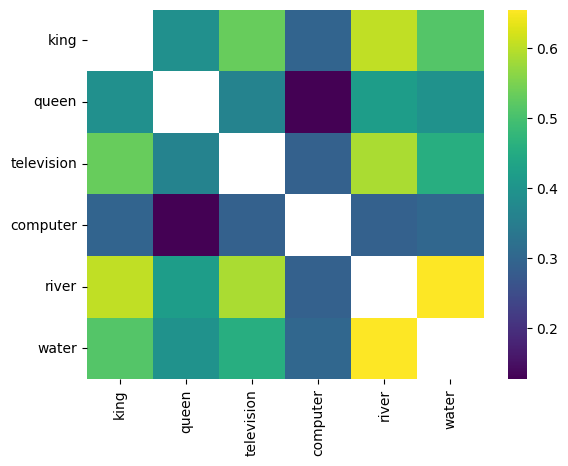

In [ ]:
words = ['king', 'queen',
         'television', 'computer',
         'river', 'water']

# Load the trained model
skipgram_model_path = os.path.join(model_dir, "model.pt")
vocab_path = os.path.join(model_dir, "vocab.pt")

# Create embeddings
word_embedding_ops = WordEmbeddingOps(skipgram_model_path, vocab_path)

# Find similarities between all pairs of words using COSINE SIMILARITY
w2v_vectors, w2v_similarity = word_embedding_ops.get_word_similarity(words, similarity_func='cosine')
sim = w2v_similarity.copy()
np.fill_diagonal(sim, np.nan)
vmin = np.nanmin(sim)
vmax = np.nanmax(sim)

# Visualise on a heatmap
sns.heatmap(
    pd.DataFrame(sim, columns=words, index=words),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)

<Axes: >

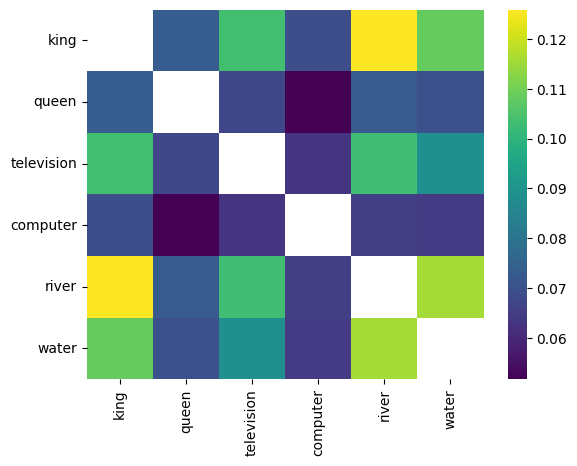

In [ ]:
# Find similarities between all pairs of words using EUCLIDEAN SIMILARITY
w2v_vectors, w2v_similarity = word_embedding_ops.get_word_similarity(words, similarity_func='euclidean')
sim = w2v_similarity.copy()
np.fill_diagonal(sim, np.nan)
vmin = np.nanmin(sim)
vmax = np.nanmax(sim)

# Visualise on a heatmap
sns.heatmap(
    pd.DataFrame(sim, columns=words, index=words),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)

Now that you are satisfied with the fact that embeddings do carry some meaning, you try to deep dive into how the similarity between related and unrelated words relate

In [ ]:
def experiment_related_vs_unrelated_words(word_embedding_ops):
    word_relationships = {
        'king': {
            'related': ['queen', 'prince', 'royal', 'throne', 'kingdom'],
            'unrelated': ['computer', 'ocean', 'bicycle', 'coffee', 'mountain']
        },
        'ocean': {
            'related': ['sea', 'wave', 'coast', 'marine', 'island'],
            'unrelated': ['book', 'war', 'music', 'building', 'science']
        },
        'year': {
            'related': ['month', 'day', 'time', 'period', 'decade'],
            'unrelated': ['ocean', 'food', 'building', 'bicycle', 'coffee']
        }
    }

    related_scores = []
    unrelated_scores = []

    for word, relations in word_relationships.items():
        if word not in word_embedding_ops.vocab:
            continue

        print(f"Target word = '{word}'")
        word_vec = word_embedding_ops.embeddings[word_embedding_ops.vocab[word]]

        print(f"Similarities with related words:")
        word_related_scores = []
        for rel in relations['related']:
            if rel in word_embedding_ops.vocab:
                rel_vec = word_embedding_ops.embeddings[word_embedding_ops.vocab[rel]]
                sim = word_embedding_ops.cosine_similarity(word_vec, rel_vec)
                related_scores.append(sim)
                word_related_scores.append(sim)
                print(f"{word} and {rel} - {sim:.3f}")

        print(f"Similarities with unrelated words:")
        word_unrelated_scores = []
        for unrel in relations['unrelated']:
            if unrel in word_embedding_ops.vocab:
                unrel_vec = word_embedding_ops.embeddings[word_embedding_ops.vocab[unrel]]
                sim = word_embedding_ops.cosine_similarity(word_vec, unrel_vec)
                unrelated_scores.append(sim)
                word_unrelated_scores.append(sim)
                print(f"{word} and {unrel} - {sim:.3f}")

        if word_related_scores and word_unrelated_scores:
            avg_rel = np.mean(word_related_scores)
            avg_unrel = np.mean(word_unrelated_scores)
            diff = avg_rel - avg_unrel
            print(f"\'{word}' summary:")
            print(f"Avg related: {avg_rel:.3f}")
            print(f"Avg unrelated: {avg_unrel:.3f}")

        print()

# The average similarity between related words should be higher than that of unrelated words.
# This indicates that the embeddings carry meaning.
experiment_results = experiment_related_vs_unrelated_words(word_embedding_ops)

Target word = 'king'
Similarities with related words:
king and queen - 0.390
king and prince - 0.443
king and royal - 0.510
king and throne - 0.348
king and kingdom - 0.578
Similarities with unrelated words:
king and computer - 0.294
king and ocean - 0.467
king and bicycle - 0.243
king and coffee - 0.259
king and mountain - 0.420
'king' summary:
Avg related: 0.454
Avg unrelated: 0.337

Target word = 'ocean'
Similarities with related words:
ocean and sea - 0.508
ocean and wave - 0.442
ocean and coast - 0.447
ocean and marine - 0.334
ocean and island - 0.537
Similarities with unrelated words:
ocean and book - 0.409
ocean and war - 0.494
ocean and music - 0.471
ocean and building - 0.418
ocean and science - 0.345
'ocean' summary:
Avg related: 0.454
Avg unrelated: 0.427

Target word = 'year'
Similarities with related words:
year and month - 0.427
year and day - 0.458
year and time - 0.652
year and period - 0.410
year and decade - 0.362
Similarities with unrelated words:
year and ocean - 0.

Timothy is happy with your findings. But like all good guides, he has suggestions. Instead of matching similarities between already selected words, Timothy wants you to explore more openly to see if the embeddings carry any meaning. He wants you to take a words and find the words closest in the embeddings space to it, to verify if they are indeed related words.

In [ ]:
word_embedding_ops.find_similar_words('king')

[('later', np.float32(0.72117645)),
 ('john', np.float32(0.72019035)),
 ('war', np.float32(0.71036315)),
 ('third', np.float32(0.7098454)),
 ('general', np.float32(0.7077))]

In [ ]:
word_embedding_ops.find_similar_words('market')

[('2', np.float32(0.536328)),
 ('september', np.float32(0.5194149)),
 ('united', np.float32(0.516655)),
 ('led', np.float32(0.5161794)),
 ('3', np.float32(0.5088524))]

In [ ]:
word_embedding_ops.find_similar_words('fast')

[('play', np.float32(0.47256923)),
 ('could', np.float32(0.455989)),
 ('times', np.float32(0.45027348)),
 ('well', np.float32(0.4494155)),
 ('large', np.float32(0.44797686))]

Donot be disappointed if you do not see synonyms in the results here. This is a miniature embedding model and hence word relationships are not very well baked in it.

Timothy is aware of the problems of training a SkipGram model from scratch. And to his delight he discovers the ```word2vec-google-news-300``` pretrained Word2Vec model that generated 300d embeddings and is pretrained on a huge corpus, thus gives much more meaningful word embeddings. This finding is going to help you in the next segment of this assignment.

## 2.3 Evaluating the goodness of `word2vec-google-news-300` embeddings

In [ ]:
def download_word2vec_model(model_name="word2vec-google-news-300"):
    """
    Download word2vec model using gensim's built-in downloader.

    Args:
        model_name (str): Name of the model to download.

    Returns:
        str: Path to the downloaded model

    Raises:
        ValueError: If the specified model is not available
        Exception: For other download or processing errors
    """
    try:
        # Check if model is available
        available_models = api.info()['models'].keys()
        if model_name not in available_models:
            raise ValueError(
                f"Model '{model_name}' not found. Available models: {', '.join(available_models)}"
            )

        print(f"Downloading {model_name}...")
        model_path = api.load(model_name, return_path=True)
        print(f"Model downloaded successfully to: {model_path}")

        return model_path

    except Exception as e:
        print(f"Error downloading model: {str(e)}")
        raise

# This might take up to five minutes in the first run, so please be patient!
word2vec_path = download_word2vec_model()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model downloaded successfully to: /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


<Axes: >

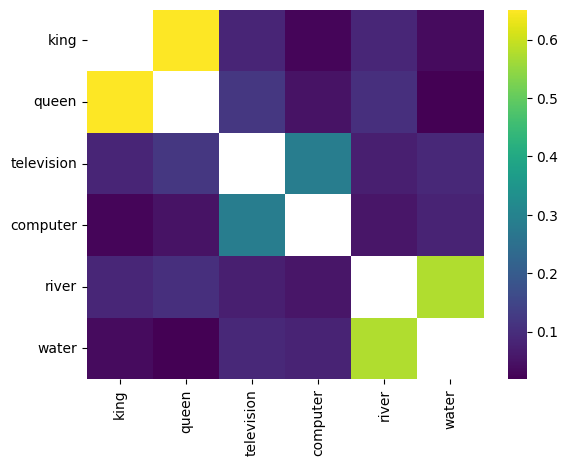

In [ ]:
words = ['king', 'queen',
         'television', 'computer',
         'river', 'water']

# Create embeddings
word2vec_word_embedding_ops = WordEmbeddingOps(word2vec_path, vocab_path=None, trained_skipgram_model=False)

# Find similarities between all pairs of words using COSINE SIMILARITY
w2v_vectors, w2v_similarity = word2vec_word_embedding_ops.get_word_similarity(words, similarity_func='cosine')
sim = w2v_similarity.copy()
np.fill_diagonal(sim, np.nan)
vmin = np.nanmin(sim)
vmax = np.nanmax(sim)

# Visualise on a heatmap
sns.heatmap(
    pd.DataFrame(sim, columns=words, index=words),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)

<Axes: >

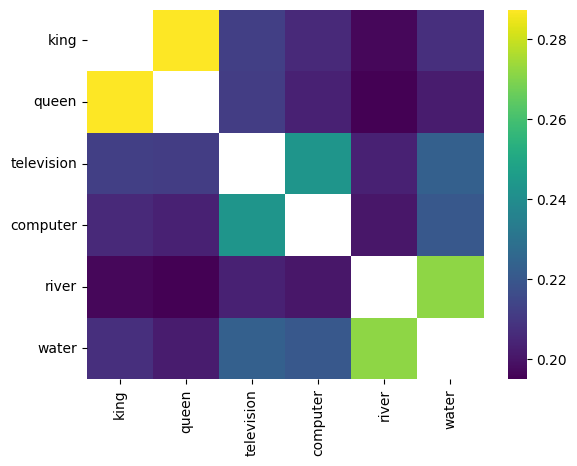

In [ ]:
# Find similarities between all pairs of words using EUCLIDEAN SIMILARITY
w2v_vectors, w2v_similarity = word2vec_word_embedding_ops.get_word_similarity(words, similarity_func='euclidean')
sim = w2v_similarity.copy()
np.fill_diagonal(sim, np.nan)
vmin = np.nanmin(sim)
vmax = np.nanmax(sim)

# Visualise on a heatmap
sns.heatmap(
    pd.DataFrame(sim, columns=words, index=words),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)

In [ ]:
# The average similarity between related words should be higher than that of unrelated words.
# This indicates that the embeddings carry meaning.
experiment_results = experiment_related_vs_unrelated_words(word2vec_word_embedding_ops)

Target word = 'king'
Similarities with related words:
king and queen - 0.651
king and prince - 0.616
king and royal - 0.524
king and throne - 0.542
king and kingdom - 0.521
Similarities with unrelated words:
king and computer - 0.028
king and ocean - 0.065
king and bicycle - 0.046
king and coffee - 0.083
king and mountain - 0.169
'king' summary:
Avg related: 0.571
Avg unrelated: 0.078

Target word = 'ocean'
Similarities with related words:
ocean and sea - 0.764
ocean and wave - 0.214
ocean and coast - 0.496
ocean and marine - 0.511
ocean and island - 0.410
Similarities with unrelated words:
ocean and book - 0.066
ocean and war - 0.101
ocean and music - 0.091
ocean and building - 0.110
ocean and science - 0.189
'ocean' summary:
Avg related: 0.479
Avg unrelated: 0.111

Target word = 'year'
Similarities with related words:
year and month - 0.765
year and day - 0.482
year and time - 0.422
year and period - 0.334
year and decade - 0.578
Similarities with unrelated words:
year and ocean - 0.

In [ ]:
word2vec_word_embedding_ops.find_similar_words('king')

[('kings', np.float32(0.71380454)),
 ('queen', np.float32(0.6510956)),
 ('monarch', np.float32(0.6413195)),
 ('crown_prince', np.float32(0.62042195)),
 ('prince', np.float32(0.6159994))]

In [ ]:
word2vec_word_embedding_ops.find_similar_words('market')

[('markets', np.float32(0.7666049)),
 ('marketplace', np.float32(0.6955361)),
 ('themarket', np.float32(0.59914595)),
 ('maket', np.float32(0.5920898)),
 ('mkt', np.float32(0.58593446))]

In [ ]:
word2vec_word_embedding_ops.find_similar_words('fast')

[('quick', np.float32(0.5701606)),
 ('rapidly', np.float32(0.5525555)),
 ('Fast', np.float32(0.5490224)),
 ('quickly', np.float32(0.53937227)),
 ('slow', np.float32(0.53136927))]

Pretrained embeddings are thus able to encode semantic information about words and are hence essential tools in understanding the semantics of natural language text. With this motivation, you move on to the final part of this assignment.

# 3. Discriminative Classification

After spending days multiplying probabilities, Timothy stumbles upon a different philosophy of classification. Instead of asking *how* a document is generated, this approach asks a simpler, sharper question:

> *Given a document, which class does it belong to?*

This family of methods is called **discriminative classification**.

Let:

- Let $d = (w_1, w_2, \dots, w_n)$ be a document or a piece of text with multiple words
- Let $c$ be a class (Politics, Sports, Technology, etc.)

Unlike generative models, which learn the $ P(d \mid c) $, discriminative models focus directly on learning $ P(c \mid d) $,
or equivalently, a **decision boundary** that separates classes in a feature space.

Your task now is to convert documents into numerical representations and learn a function
$
f(d) \rightarrow c
$
that assigns each document to one of the news categories.


## Word Representations

To construct decision boundaries, documents must first be represented as vectors. Timothy explores two popular representations.

### (a) Bag-of-Words (BoW)

In the Bag-of-Words representation, a document is treated as an **unordered collection of words**, ignoring grammar and word order.

Let the vocabulary be
$$
V = {w_1, w_2, \dots, w_{|V|}}.
$$

A document (d) is represented as a vector
$$
x_d \in \mathbb{R}^{|V|}
$$

where each dimension corresponds to a word in the vocabulary. The $i$-th component is defined as:
$$
(x_d)_i = \text{count}(w_i \in d)
$$

For example, if our vocabulary looks like {0: <UNK>, 1: tea, 2: coffee, 3: hot, 4: cold, 5: is, 6: the, 7:not, 8:enough}, then the sentence "The hot coffee is not hot enough" will be represented as $[0, 0, 1, 2, 0, 1, 1, 1, 1]$

Using this representation, we can train a discriminative classifier that learns a weight matrix $W$ and bias $b$, computing class scores as:
$$
\mathbf{s} = W \cdot \mathbf{x}_d + b.
$$

The predicted class is:
$$
c_{pred} = \arg\max_c \space s_c.
$$

While simple and effective, BoW representations suffers from two major problems,

- High dimensionality - The size of the vector representation increases with increasing size of vocabularies. This makes BOW representations non-scalable.

- Lack of semantic understanding - Words like *“election”* and *“vote”* will be treated as completely unrelated in this scheme, while they should ideally be treated somewhat similarly.

### (b) Word2Vec-Based Representation

To overcome the limitations of BoW, Timothy realises that you can use the **Word2Vec embeddings** trained earlier. But you also saw that the trained embeddings were not the best. So you suggested that you use the pretrained ```word2vec-google-news-300``` embedddings and train a simple softmax classifier.

Each word $ w \in V $ is mapped to a dense vector:
$$
e_w \in \mathbb{R}^{d},
$$

A document is represented by aggregating the embeddings of its words. A common approach is mean pooling:

$$
x_d = \frac{1}{n} \sum_{i=1}^{n} (e_w)_i,
$$

where $ d = (w_1, w_2, \dots, w_n) $. Here $ d \ll |V|$. Hence, this produces a dense, low-dimensional representation that captures semantic information.

The same discriminative classifier is then applied:
$$
s = W \cdot x_d + b,
\qquad
c_{pred} = \arg\max_c \space s_c.
$$

Unlike Bag-of-Words, Word2Vec-based representations allow documents with similar meanings to lie close together in the feature space, resulting in smoother and more meaningful decision boundaries.


Timothy hands you these tools and you are finally ready to draw clean lines between the different news categories using Discriminative Classification.


**Note:**
Donot worry about the training code below, you are only expected to implement the topics discussed in our lecture and the rest is already provided to you.



## 3.1 Bag-of-Words Classifier

In [ ]:
# ==== BEGIN EVALUATION PORTION

def softmax(z):
    """
    Define the softmax function
    The softmax function takes as input a vector z
    and outputs a vector of the same shape,
    where each element is between 0 and 1

    Args:
        z (np.array): Input array
    Returns:
        np.array: Softmax of the input array
    """
    # BEGIN CODE : softmax

    # ADD YOUR CODE HERE
    shifted_z=z-np.max(z,axis=1,keepdims=True)
    exp_vals=np.exp(shifted_z)
    row_sums=np.sum(exp_vals,axis=1,keepdims=True)
    return exp_vals / row_sums


    # END CODE

# ==== END EVALUATION PORTION

In [ ]:
# ==== BEGIN EVALUATION PORTION

class BagOfWordsClassifier:
    def __init__(self, model_dir, min_freq=1):
        """
        Initialize the Bag of Words classifier.

        Args:
            model_dir (str): Directory to save/load trained classifier parameters.
            min_freq (int): Minimum frequency threshold for a word to be included in vocabulary.
                           Words appearing less than min_freq times will be treated as UNK token.
                           Default: 1 (include all words)

        Attributes:
            vocabulary (dict): Word to index mapping, including special UNK token
                Example: {'<UNK>': 0, 'good': 1, 'movie': 2}
            W: The weight matrix
            b: The bias vector
            lr (float): Learning rate for gradient descent
            epochs (int): Number of training epochs
            min_freq (int): Minimum frequency threshold for vocabulary inclusion
                Example: If min_freq=2, words must appear at least twice to be included
            model_dir (string): Directory to save/load trained classifier parameters.
        """
        self.vocabulary = None
        self.W = None
        self.b = None
        self.min_freq = min_freq
        self.model_dir = model_dir


    def text_to_bow(self, texts):
        """
        Convert texts to bag-of-words feature vectors using the vocabulary,
        where each element represents the count of occurrences of the word in the text.
        Words not in vocabulary are mapped to UNK token and the first column should represent UNK tokens.
        Use preprocess_text function for preprocessing the texts.

        Args:
            texts (list): List of text documents
                Example: ["government passes new law", "government announces new policy"]

        Returns:
            np.array: Document-term matrix with UNK handling
                      Shape of output should be (n_documents, len(vocabulary))

            Example: For vocabulary {'<UNK>':0, 'government':1, 'new':2, 'announces':3} with min_freq=2:
                array([
                      [2, 1, 1, 0],  # First doc: 1 UNK ('passes'), 1 'government', 1 'new', 0 'announces'
                      [1, 1, 1, 1]   # Second doc: 0 UNKs, 1 'government', 1 'new', 1 'announces'
                ])
        """
        # BEGIN CODE : bow.text_to_bow

        # ADD YOUR CODE HERE
        no_of_doc=len(texts)
        no_of_words=len(self.vocabulary)
        bow_matrix=np.zeros((no_of_doc,no_of_words))
        for i,text in enumerate(texts):
            tokens=preprocess_text(text)
            for token in tokens:
                if token in self.vocabulary:
                    index = self.vocabulary[token]
                    bow_matrix[i,index] += 1
                else:
                    bow_matrix[i,0] += 1
        return bow_matrix

        # END CODE

    def fit(self, train_df, lr=0.1, epochs=40):
        """
        Train the classifier on text documents.

        Args:
            train_df (pd.DataFrame): Must contain columns ["text", "label"]
            lr (float): Learning rate for gradient descent
            epochs (int): Number of training epochs
        """

        # Extract features and labels
        X = train_df["text"].values
        y = train_df["label"].values

        # Split into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Create vocabulary from training texts
        self.vocabulary = create_vocabulary(X_train, min_freq=self.min_freq)

        # Convert texts to BoW features
        X_train_bow = self.text_to_bow(X_train)
        X_val_bow = self.text_to_bow(X_val)

        # Get shapes
        n_samples, n_features = X_train_bow.shape
        n_classes = len(np.unique(y_train))

        # One-hot encode labels
        y_train_onehot = np.zeros((n_samples, n_classes))
        y_train_onehot[np.arange(n_samples), y_train] = 1

        n_val_samples = X_val_bow.shape[0]
        y_val_onehot = np.zeros((n_val_samples, n_classes))
        y_val_onehot[np.arange(n_val_samples), y_val] = 1

        # Initialise weights and bias
        self.W = np.zeros((n_features, n_classes))
        self.b = np.zeros((1, n_classes))

        # Training loop
        for ep in range(1, epochs + 1):
            # Forward pass
            logits = X_train_bow @ self.W + self.b
            probs = softmax(logits)

            # Gradient computation
            error = probs - y_train_onehot
            dW = (X_train_bow.T @ error) / n_samples
            db = np.mean(error, axis=0, keepdims=True)

            # Update parameters
            self.W -= lr * dW
            self.b -= lr * db

            # Validation in every 5 epochs
            if ep % 10 == 0:
                train_loss = -np.sum(y_train_onehot * np.log(probs + 1e-15)) / n_samples
                val_logits = X_val_bow @ self.W + self.b
                val_probs = softmax(val_logits)
                val_loss = -np.sum(y_val_onehot * np.log(val_probs + 1e-15)) / n_val_samples
                print(f"Epoch {ep:3d} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    def predict(self, X_text):
        """
        Predict classes for new documents.

        Args:
            X_text (list): List of text documents
                Example: ["Kohli scored a century", "Nvidia launches NVLink 6",
                          "US President resigns"]

        Returns:
            list: Predicted class labels
                Example: [1, 0, 3] # 0(Tech) 1(Sports) 2(Business) 3(Politics)
        """
        # Convert texts to BoW features
        X_bow = self.text_to_bow(X_text)

        # Make predictions
        logits = X_bow @ self.W + self.b
        probs = softmax(logits)
        return np.argmax(probs, axis=1)

    def get_class_probabilities(self, X_text):
        """
        Calculate prediction confidence scores for each class. In other words,
        return the probability distribution over classes.

        Sanity Check:
          - Each row sums to 1.0

        Args:
            X_text (list): List of text documents
                Example: ["Kohli scored a century", "Nvidia launches NVLink 6",
                          "US President resigns"]

        Returns:
            np.array: Confidence scores for each class (values 0-1)
                Example: array([0.1, 0.9, 0.12, 0.01])  # 90% confidence for Sports class
        """

        X_bow = self.text_to_bow(X_text)
        logits = X_bow @ self.W + self.b
        return self.softmax(logits)

    def save_model(self):
        """
        Save final model to directory
        """
        os.makedirs(self.model_dir, exist_ok=True)
        save_path = os.path.join(self.model_dir, "bow_classifier.pkl")
        state = {
            "W": self.W,
            "b": self.b
        }
        joblib.dump(state, save_path)
        print(f"Model saved to {save_path}")


# ==== END EVALUATION PORTION

In [ ]:
def evaluate_classifier(y_true, y_pred):
    """
    Calculate classification accuracy.
    Accuracy = (number of correct predictions) / (total number of predictions)

    Args:
        y_true (list): True class labels
            Example: [0, 1, 3, 1]
        y_pred (list): Predicted class labels
            Example: [0, 2, 3, 1]

    Returns:
        float: Accuracy (proportion of correct predictions)
            Example: 0.75 (3 correct predictions out of 4)
    """
    if len(y_true) != len(y_pred):
        raise ValueError("Length of true and predicted labels must match")

    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    return correct / len(y_true)

In [ ]:
# You can play with the values of the hyperparameters and notice how the accuracy
# changes accordingly.

# ADD YOUR CODE HERE

MIN_FREQ = 2 # Minimum number of times a word has to be encountered to add it to the vocabulary
LEARNING_RATE = 0.1 # Learning rate
NUM_EPOCHS = 50 # Number of epochs to train

In [ ]:
# Train and evaluate BoW classifier
print("Training Bag of Words classifier...")
model_dir = f'weights/bow_classifier'
bow_clf = BagOfWordsClassifier(model_dir, min_freq = MIN_FREQ)
bow_clf.fit(train_df, lr = LEARNING_RATE, epochs = NUM_EPOCHS)
bow_clf.save_model()

X_test = test_df["text"].values
y_test = test_df["label"].values

bow_predictions = bow_clf.predict(X_test)
bow_accuracy = evaluate_classifier(y_test, bow_predictions)

# Above 80% validation accuracy is good!
print(f"BoW Validation Accuracy: {bow_accuracy:.4f}")

Training Bag of Words classifier...
Epoch  10 - Train Loss: 0.9384 - Val Loss: 0.9734
Epoch  20 - Train Loss: 0.6241 - Val Loss: 0.7183
Epoch  30 - Train Loss: 0.4718 - Val Loss: 0.5912
Epoch  40 - Train Loss: 0.3824 - Val Loss: 0.5154
Epoch  50 - Train Loss: 0.3232 - Val Loss: 0.4648
Model saved to weights/bow_classifier/bow_classifier.pkl
BoW Validation Accuracy: 0.9311


## 3.2 Word2Vec-based Classifier

Here, Timothy averages word embeddings or uses pooling:

$$
\mathbf{d} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{v}_{w_i}
$$

This dense representation feeds into a classifier.

The question Timothy wants answered:

> Does meaning beat counting?

We will use the pre-trained word2vec model, previously downloaded for skipgram assessment

In [ ]:
def download_word2vec_model(model_name="word2vec-google-news-300"):
    """
    Download word2vec model using gensim's built-in downloader.

    Args:
        model_name (str): Name of the model to download.

    Returns:
        str: Path to the downloaded model

    Raises:
        ValueError: If the specified model is not available
        Exception: For other download or processing errors
    """
    try:
        # Check if model is available
        available_models = api.info()['models'].keys()
        if model_name not in available_models:
            raise ValueError(
                f"Model '{model_name}' not found. Available models: {', '.join(available_models)}"
            )

        print(f"Downloading {model_name}...")
        model_path = api.load(model_name, return_path=True)
        print(f"Model downloaded successfully to: {model_path}")

        return model_path

    except Exception as e:
        print(f"Error downloading model: {str(e)}")
        raise

# This might take up to five minutes in the first run, so please be patient!
word2vec_path = download_word2vec_model()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model downloaded successfully to: /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# ==== BEGIN EVALUATION PORTION

class Word2VecClassifier:
    def __init__(self, word2vec_path, model_dir):
        """
        Word2Vec-based classifier (multiclass softmax):

        Workflow:
        1. Load a pre-trained Word2Vec model.
        2. Represent each document as the average of its Word2Vec embeddings.
        3. Train a linear softmax classifier (W, b) on top of these averaged vectors
           for multiclass classification using gradient descent.

        Attributes:
            word_vectors (KeyedVectors): Loaded Word2Vec embeddings for all words in the vocabulary.
            W (np.array or torch.Tensor): Weight matrix of shape (embedding_dim, n_classes), initialized later.
            b (np.array or torch.Tensor): Bias vector of shape (n_classes,), initialized later.
            model_dir (str): Directory to save/load trained classifier parameters.
        """
        # Load the Word2Vec model
        self.word_vectors = KeyedVectors.load_word2vec_format(
            word2vec_path, binary=True)

        # Define W and b for the multiclass classifier
        self.W = None
        self.b = None
        # Directory to save the model
        self.model_dir = model_dir

    def text_to_w2v(self, texts):
        """
        Convert list of texts into document vectors by averaging word vectors
        from the Word2Vec embeddings.

        For each text document:
          - Preprocess using ``preprocess_text`` to get tokens
          - Get vector embedding corresponding to each token inthevocabulary
          - Average the embeddings to get a document vector.
          - If no word is present in the vocabulary, return a zero vector.

        Args:
            texts (list): List of text documents
                Example: ["Kohli scored a century", "Nvidia launches NVLink 6",
                          "US President resigns"]
        Returns:
            np.array: Document vectors with shape (n_documents, EMBED_DIMENSION)
        """
        # BEGIN CODE : w2v.text_to_w2v

        # ADD YOUR CODE HERE
        no_of_docs=len(texts)
        d=self.word_vectors.vector_size
        w2v_matrix=np.zeros((no_of_docs,d))
        for i,text in enumerate(texts):
            tokens=preprocess_text(text)
            valid_token_count=0
            for token in tokens:
                if token in self.word_vectors:
                  w2v_matrix[i]+=self.word_vectors[token]
                  valid_token_count+=1
            if valid_token_count>0:
              w2v_matrix[i]/=valid_token_count
        return w2v_matrix


        # END CODE

    def fit(self, train_df, lr=0.1, epochs=40):
        """
        Train the classifier on the provided training dataframe.

        Args:
            train_df (pd.DataFrame): Must contain columns ["text", "label"]
            lr (float): Learning rate for gradient descent
            epochs (int): Number of training epochs
        """
        X = train_df["text"].values
        y = train_df["label"].values

        # Split into training and validation sets (same as BoW)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Convert texts to averaged word2vec vector
        X_train_vec = self.text_to_w2v(X_train)
        X_val_vec = self.text_to_w2v(X_val)

        X_train_vec /= np.linalg.norm(X_train_vec, axis=1, keepdims=True) + 1e-8
        X_val_vec   /= np.linalg.norm(X_val_vec, axis=1, keepdims=True) + 1e-8

        n_samples, n_features = X_train_vec.shape
        n_classes = len(np.unique(y_train))

        # One-hot encode labels
        y_train_onehot = np.zeros((n_samples, n_classes))
        y_train_onehot[np.arange(n_samples), y_train] = 1

        n_val_samples = X_val_vec.shape[0]
        y_val_onehot = np.zeros((n_val_samples, n_classes))
        y_val_onehot[np.arange(n_val_samples), y_val] = 1

        # Initialise weights and bias
        self.W = np.zeros((n_features, n_classes))
        self.b = np.zeros((1, n_classes))

        # Training loop
        for ep in range(1, epochs + 1):
            logits = X_train_vec @ self.W + self.b
            probs = softmax(logits)

            error = probs - y_train_onehot
            dW = (X_train_vec.T @ error) / n_samples
            db = np.mean(error, axis=0, keepdims=True)

            self.W -= lr * dW
            self.b -= lr * db

            if ep % 10 == 0:
                train_loss = -np.sum(y_train_onehot * np.log(probs + 1e-15)) / n_samples

                val_logits = X_val_vec @ self.W + self.b
                val_probs = softmax(val_logits)
                val_loss = -np.sum(y_val_onehot * np.log(val_probs + 1e-15)) / n_val_samples

                print(f"Epoch {ep:3d} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    def predict(self, X_text):
        """
        Predict classes for new documents.

        Args:
            X_text (list): List of text documents
                Example: ["Kohli scored a century", "Nvidia launches NVLink 6",
                "US President resigns"]

        Returns:
            list: Predicted class labels
                Example: ["sports", "tech", "politics]
        """
        X_vec = self.text_to_w2v(X_text)
        logits = X_vec @ self.W + self.b
        probs = softmax(logits)
        return np.argmax(probs, axis=1)

    def get_class_probabilities(self, X_text):
        """
        Return probability distribution over classes.
        """
        X_vec = self.text_to_w2v(X_text)
        logits = X_vec @ self.W + self.b
        return softmax(logits)

    def save_model(self):
        """
        Save final model to directory
        """
        os.makedirs(self.model_dir, exist_ok=True)
        save_path = os.path.join(self.model_dir, "w2v_classifier.pkl")
        state = {
            "W": self.W,
            "b": self.b
        }
        joblib.dump(state, save_path)
        print(f"Model saved to {save_path}")

# ==== END EVALUATION PORTION

In [ ]:
# Try out different combinations of NUM_EPOCHS and LEARNING_RATE and check how
# accuracy and convergence changes.

# ADD YOUR CODE HERE

NUM_EPOCHS = 200 # Number of epochs to train the model for
LEARNING_RATE = 0.5 # Learning rate for training

In [ ]:
model_dir = f'word2vec_classifier'

print("Loading Word2Vec classifier...")
w2v_clf = Word2VecClassifier(word2vec_path, model_dir)

print("Training Word2Vec classifier...")
w2v_clf.fit(train_df, lr=LEARNING_RATE, epochs=NUM_EPOCHS)
w2v_clf.save_model()

X_test = test_df["text"].values
y_test = test_df["label"].values

w2v_predictions = w2v_clf.predict(X_test)
w2v_accuracy = evaluate_classifier(y_test, w2v_predictions)

# Above 80% validation accuracy is good!
print(f"Word2Vec Validation Accuracy: {w2v_accuracy:.4f}")

Loading Word2Vec classifier...
Training Word2Vec classifier...
Epoch  10 - Train Loss: 1.5165 - Val Loss: 1.5087
Epoch  20 - Train Loss: 1.4291 - Val Loss: 1.4240
Epoch  30 - Train Loss: 1.3499 - Val Loss: 1.3474
Epoch  40 - Train Loss: 1.2778 - Val Loss: 1.2777
Epoch  50 - Train Loss: 1.2123 - Val Loss: 1.2143
Epoch  60 - Train Loss: 1.1527 - Val Loss: 1.1566
Epoch  70 - Train Loss: 1.0984 - Val Loss: 1.1040
Epoch  80 - Train Loss: 1.0487 - Val Loss: 1.0560
Epoch  90 - Train Loss: 1.0034 - Val Loss: 1.0121
Epoch 100 - Train Loss: 0.9618 - Val Loss: 0.9718
Epoch 110 - Train Loss: 0.9237 - Val Loss: 0.9349
Epoch 120 - Train Loss: 0.8887 - Val Loss: 0.9010
Epoch 130 - Train Loss: 0.8564 - Val Loss: 0.8698
Epoch 140 - Train Loss: 0.8266 - Val Loss: 0.8409
Epoch 150 - Train Loss: 0.7990 - Val Loss: 0.8143
Epoch 160 - Train Loss: 0.7735 - Val Loss: 0.7896
Epoch 170 - Train Loss: 0.7498 - Val Loss: 0.7667
Epoch 180 - Train Loss: 0.7277 - Val Loss: 0.7454
Epoch 190 - Train Loss: 0.7072 - Val 

# Closing Note

You report your findings to Timothy, close the final paper and look at your codebase.

- You understand the methods.
- You have implemented the methods from scratch.

Timothy's newsroom is ready.

And so are you.